In [2]:
!pip install -U duckduckgo-search langchain-community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.7 MB/s eta 0:00:0031m13.2 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [duckduckgo-search]


In [3]:
from dotenv import load_dotenv

load_dotenv()

True

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")
small_llm = ChatOpenAI(model="gpt-4o-mini")

In [5]:
from langchain_core.tools import tool

@tool
def add(a : int, b : int) -> int:
    """숫자 a와 b를 더합니다."""
    return a + b

@tool
def multiply(a : int, b : int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a * b

In [8]:
from langchain_community.tools import DuckDuckGoSearchResults

search_tool = DuckDuckGoSearchResults()

In [9]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search_tool]
tool_node = ToolNode(tool_list)

In [10]:
llm_with_tools = small_llm.bind_tools(tool_list)

In [6]:
query = '3 곱하기 5는?'
ai_message = llm_with_tools.invoke(query)

In [7]:
# tool_node invoke 하기 위해서는 마지막 메시지가 ai_message 이어야 한다.
tool_node.invoke({'messages': [ai_message]})

{'messages': [ToolMessage(content='15', name='multiply', tool_call_id='call_clZYsMcSn2Nbd6y9Gje32uvb')]}

In [11]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [12]:
def agent(state: MessagesState):
    messages = state['messages']
    response = llm_with_tools.invoke(messages)
    return {'messages': response}

In [13]:
def should_continue(state: MessagesState):
    message = state['messages']
    last_ai_message = message[-1]
    if last_ai_message.tool_calls:
        return 'tools'

    return 'end'

In [14]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [15]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue,
    {
        'end': END,
        'tools': 'tools'
    }
)
graph_builder.add_edge('tools', 'agent')

In [16]:
graph = graph_builder.compile()

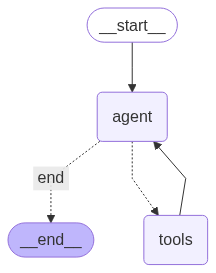

In [17]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages' : [HumanMessage('버락 오바마가 태어난 도시의 화폐 단위는 무엇인가요? ')]}, stream_mode='values') :
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

버락 오바마가 태어난 도시의 화폐 단위는 무엇인가요? 
================================== Ai Message ==================================

버락 오바마는 하와이주 호놀룰루에서 태어났습니다. 호놀룰루는 미국에 위치해 있으며, 화폐 단위는 미국 달러(USD)입니다.
